<a href="https://colab.research.google.com/github/richienrg/Optical-Character-Recognition-Flask-App/blob/main/TextExtractionFromImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text Extraction from Images

In this project I will be working on extracting text from images.  After extracting the text I will apply some basic functions of OpenCV to enhance the text and improve accuracy.  

First I will import the request library for fetching urls for git files and images. 

In [1]:
import requests

Downloading the tesseract which is required for the pytessereact library to run and save the file at the path with open() function

In [2]:
# download the tesseract-ocr file
r = requests.get("https://raw.githubusercontent.com/tesseract-ocr/tessdata/4.00/ind.traineddata", stream=True)

#writing the data to a file
with open("/usr/share/tesseract-ocr/4.00/tessdata/ind.traineddata", "wb") as file:
  for block in r.iter_content(chunk_size = 1024):
    if block:
      file.write(block)

Now I will install the libraries for ocr and I will also import IPython functions.

In [3]:
# install libraries required for optical character recognition
! apt install tesseract-ocr libtesseract-dev libmagickwand-dev

# importing IPython to clear output which is not important
from IPython.display import HTML, clear_output
clear_output()

Next, I will install pytesseract and OpenCV libraries.

In [4]:
! pip install pytesseract wand opencv-python
clear_output()

Now import the required libraries 

In [5]:
from PIL import Image
import pytesseract
import cv2
import numpy as np
from pytesseract import Output
import re

I will now open and image and resize it,  then save it for further use. 

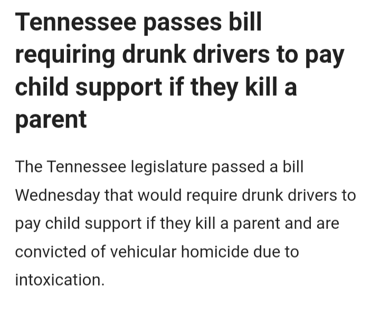

In [24]:
image = Image.open(requests.get("https://i.imgur.com/gjF4CWi.png", stream=True).raw)
image = image.resize((380,312))
image.save("sample.png")
image

Now, I will extract the text from the image with custom config.

In [25]:
custom_config = r"-l eng --oem 3 --psm 6"
text = pytesseract.image_to_string(image, config=custom_config)
print(text)

Tennessee passes bill
requiring drunk drivers to pay
child support if they kill a
parent

The Tennessee legislature passed a bill
Wednesday that would require drunk drivers to
pay child support if they kill a parent and are
convicted of vehicular homicide due to
intoxication.



The following piece of code will remove unwanted characters which you can customise depending on purpose. 

In [26]:
try: 
  text = pytesseract.image_to_string(image,lang="eng")
  characters_to_remove = "!()@-*>+-,'|£#%$&^_#"
  new_string = text
  for character in characters_to_remove:
    new_string = new_string.replace(character, "")
  print(new_string)
except IOError as e: 
  print("Error (%s)." % e)

Tennessee passes bill
requiring drunk drivers to pay
child support if they kill a
parent

The Tennessee legislature passed a bill
Wednesday that would require drunk drivers to
pay child support if they kill a parent and are
convicted of vehicular homicide due to
intoxication.



Load image into OpenCV to process it further. 

In [27]:
image = cv2.imread("sample.png")

Converting the images to grayscale allows eaasier processing.  It will only have 2 values.. 0 and 1.  There are more than 150 colour-space conversion methods available in OpenCV. 

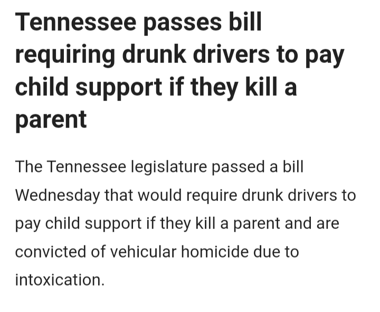

In [28]:
def get_grayscale(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = get_grayscale(image)
Image.fromarray(gray)


Now I can blur the image so I can remove the noiuse.  The function medianBlur() computes the median of all the pixels under the kernel window and the central pixel is replaced with this median value.  It is highly effective at removing noise. 

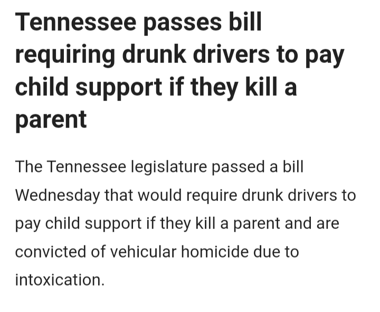

In [29]:
def remove_noise(image):
  return cv2.medianBlur(image,5)
noise = remove_noise(gray)
Image.fromarray(gray)

I will perform a threshold transformation here.  If the pixel value is greater than a threshold value, it is assigned one value (maybe white), else it is assigned to another value (maybe black).  The function is cv2.threshold in which the first argument is the source image which should be grayscale. 

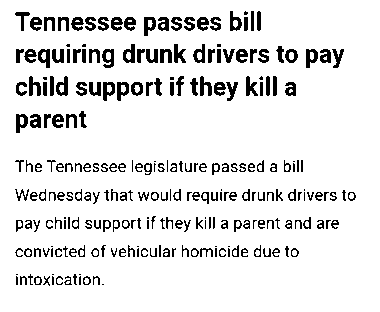

In [30]:
def thresholding(image):
  return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thresh = thresholding(gray)
Image.fromarray(thresh)


I will now perform an erode transformation.  cv2.erode() method is used to perform erosion on the image.  The basic idea of erosion is just like soil erosion only, it erodes away the boudnaries of foreground objects (helpful if the foreground is white).  It is normally performed on binary images.  It requires 2 inputs,  the original image and the kernel as the structuring element which decides the nature of the operation. 

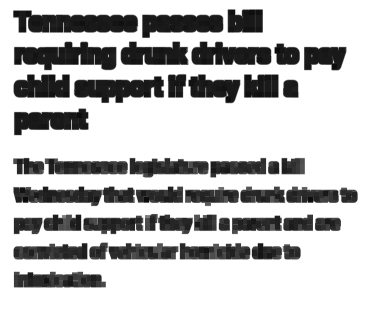

In [32]:
def erode(image):
  kernel = np.ones((5,5), np.uint8)
  return cv2.erode(image, kernel, iterations = 1)
erode = erode(gray)
Image.fromarray(erode)

Now I will perform a morphological transformation.  This is useful for opening small holes inside the foreground objects,  or small white points on the object.  

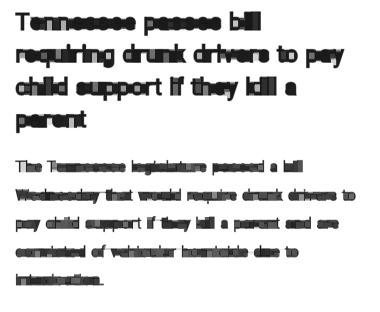

In [33]:
def opening(image):
  kernel = np.ones((5,5), np.uint8)
  return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
opening = opening(gray)
Image.fromarray(opening)


Canny transformation is used to detrect the edges of the image. 

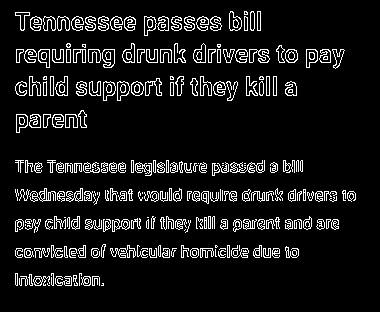

In [34]:
def canny(image):
  return cv2.Canny(image, 100, 300)
canny = canny(gray)
Image.fromarray(canny)

This section applies deskewing on the image.  Deskewing is a process whereby skew is removed by rotating an image by the same amount as its skew but in the opposite direction.  This reuslts in a horizontally and vertically aligned image where the test runs across the page rather than at an angle. 

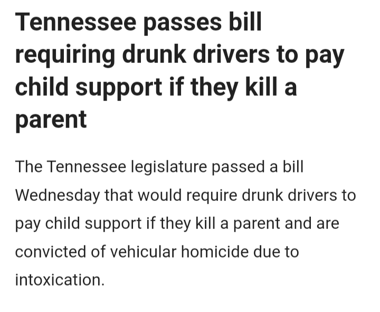

In [36]:
def deskew(image):
  coords = np.column_stack(np.where(image > 0))
  angle = cv2.minAreaRect(coords)[-1]
  if angle < -45:
    angle = -(90 + angle)
  else:
    angle = -angle
  (h, w) = image.shape[:2]
  center = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  rotated = cv2.warpAffine(image, M, (w, h), flags = cv2.INTER_CUBIC, borderMode = cv2.BORDER_REPLICATE)
  return rotated
rotated = deskew(gray)
Image.fromarray(rotated)

OpenCV comes with a function cv2.matchTemplate() which slides a tamplate image over the input image (as in 2D convolution) and compares the template and image input.  As we can see,  there is a 100% match. 

In [37]:
def match_template(image, template):
  return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
match = match_template(gray, gray)
match

array([[1.]], dtype=float32)

Now,  I will segregate every character in the text by creating a rectangle around it. 

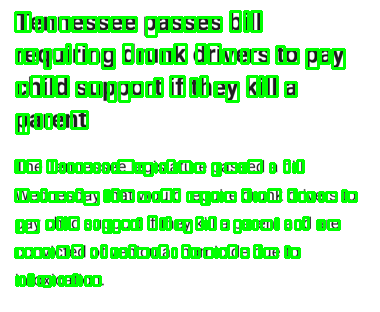

In [38]:
img = cv2.imread("sample.png")
h, w, c = img.shape
boxes = pytesseract.image_to_boxes(img)
for b in boxes.splitlines():
  b = b.split(" ")
  img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
Image.fromarray(img)

Similary I can box off a specific word or phrase. 

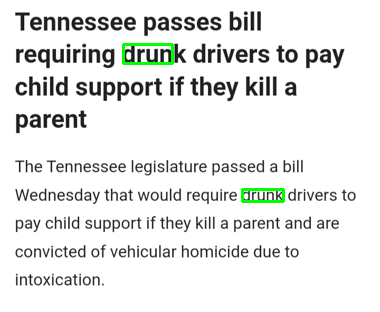

In [39]:
img = cv2.imread("sample.png")
d = pytesseract.image_to_data(img, output_type = Output.DICT)
keys = list(d.keys())

date_pattern = "drunk"

n_boxes = len(d["text"])
for i in range(n_boxes):
  if int(d["conf"][i]) > 60:
    if re.match(date_pattern, d["text"][i]):
      (x, y, w, h) = (d["left"][i], d["top"][i], d["width"][i], d["height"][i])
      img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
Image.fromarray(img)